# Fourier Neural Operator

The Fourier neural operator, originally introduced in [1,2], learns the mapping between two function spaces: $\mathcal{A} = \{a : \Omega \rightarrow R^{d_{\rm in}}\}$ and $\mathcal{U} = \{u : \Omega \rightarrow R^{d_{\rm in}}\}$, as follows:

\begin{align*}
\mathcal{G}: a \mapsto u
\end{align*}

as a surrogate model for solving parametric partial differential equations on cubes $\Omega = [0,L]^d$. There is a great [blog introduction](https://zongyi-li.github.io/blog/2020/fourier-pde/) by the authors.
This introduction delves into the detailed implementation of the Fourier neural layer.

1. Zongyi Li, Nikola Kovachki, Kamyar Azizzadenesheli, Burigede Liu, Kaushik Bhattacharya, Andrew Stuart, Anima Anandkumar, "[Fourier Neural Operator for Parametric Partial Differential Equations](https://arxiv.org/abs/2010.08895)." 
1. Nikola Kovachki, Zongyi Li, Burigede Liu, Kamyar Azizzadenesheli, Kaushik Bhattacharya, Andrew Stuart, Anima Anandkumar, "[Neural operator: Learning maps between function spaces with applications to pdes](https://www.jmlr.org/papers/v24/21-1524.html)." 



## Fourier Neural Layer

The Fourier neural layer maps the input function $f_{\rm in}: \Omega \rightarrow \mathbb{R}^{d_{\rm in}}$ to the output function $f_{\rm out}: \Omega \rightarrow \mathbb{R}^{d_{\rm out}}$, such as 

\begin{equation}
\begin{split}
    &\mathcal{L} : f_{\rm in} \mapsto f_{\rm out}, \\
    &f_{\rm out}(x) =  \sigma \Bigl(W^{l} f_{\rm in}(x) + b + \frac{1}{|\Omega|}\int_{\Omega} \kappa\bigl(x - y\bigr) f_{\rm in}(y) dy\Bigr).\
\end{split}
\end{equation}

Here, $W^{l}\in\mathbb{R}^{d_{\rm out}\times d_{\rm in}}$ and $b\in\mathbb{R}^{d_{\rm out}}$ define a pointwise local linear function, and $\kappa : \Omega \rightarrow \mathbb{R}^{d_{\rm out} \times d_{\rm in}}$ is transitional invariant kernel function. The convolution on unit cubes can be computed efficiently by Fast Fourier transform.

In general, the integral operator with continuous kernel between two infinite dimensional spaces (e.g., continuous function space $C(\Omega)$) is a compact operator, however identity mapping between two infinite dimensional spaces is not. The pointwise local linear function is able to represent such identity mappings and hence is necessary to improve the performance.




## Parametrization and Computation 

We describe how to parameterize the kernel and compute the convolution. 

### Illustrative Case: $d_{\rm in} = d_{\rm out} = 1$
Assume that $d_{\rm in} = d_{\rm out} = 1$, then we can compute the FFT of $\kappa$ and $f_{\rm in}$. Assume we have a uniform mesh on $\Omega = [0,L]^d$ with $n_x$ points $x_0, x_1, \cdots, x_{n_x - 1}$, then we have complex Fourier bases $\{\phi_k\}_{k=0}^{n_x-1}$ satisfying

\begin{align*}
\textrm{Continuous level:} \qquad \frac{1}{|\Omega|}\int \phi_i(x) \overline{\phi_k(x)} dx = \delta_{ik} \\
\textrm{Discrete level:} \qquad \frac{1}{n_x}\sum_{j = 0}^{n_x - 1} \phi_i(x_j) \overline{\phi_k(x_j)} = \delta_{ik}
\end{align*}

It is worth noticing that, that we should exclude points on the right ends, for example when $d = 1$, we have
\begin{align*}
x_0 = 0 , \, x_1 = \frac{1}{n_x}L , \, x_2 = \frac{2}{n_x}L , \, \cdots , \, x_{n_x - 1} = \frac{n_x-1}{n_x}L
\end{align*}
And $\phi_k(x) = e^{2\pi i k \frac{x}{L}}$ with $k\in\mathbb{Z}$. It is worth mentioning that when we consider only the evaluations of $\phi_k(x)$ on $x_j$, we only need $0 \leq k \leq n_x - 1$. And $\phi_k(x) = \phi_{k - n_x}(x)$, in python `fft` convention,  we keep 
$$ k = 0, 1, \cdots \lfloor \frac{n_x}{2} \rfloor, -\lfloor\frac{n_x - 1}{2}\rfloor, \cdots -2, -1.$$
And in python real FFT `rfft`, we keep 
$$ k = 0, 1, \cdots \lfloor \frac{n_x}{2} \rfloor.$$


We can define Fourier Transform and its inverse of $f_{\rm in}$
\begin{align*}
&\textrm{Fourier Transform:} \qquad  \hat{f}_{\rm in}[k]    =  \frac{1}{|\Omega|}\int  f_{\rm in}(x)  \overline{\phi_k(x)} dx    \approx \frac{1}{n_x}\sum_{j = 0}^{n_x - 1}  f_{\rm in}(x_j)  \overline{\phi_k(x_j)}  \\ 
&\textrm{Inverse Fourier Transform:}  \qquad  f_{\rm in}(x_j) = \sum_{k=0}^{n_k-1}  \hat{f}_{\rm in}[k]  \phi_k(x_j)
\end{align*}
Here the approximation becomes equality, when $f_{\rm in}(x) = \sum_{k=0}^{n_k-1}  \hat{f}_{\rm in}[k]  \phi_k(x)$.



We parameterize the kernel function by its Fourier coefficents $\{ R(k) \}$:
\begin{align*}
   \kappa(x) &= \sum_{k=0}^{n_x-1}  R(k)  \phi_k(x) 
\end{align*}

Then the convolution can be evaluated efficiently as
\begin{align*}
   \frac{1}{|\Omega|}\int_{\Omega} \kappa\bigl(x - y\bigr) f_{\rm in}(y) dy &= \sum_{k=0}^{n_x-1}  R(k)  \frac{1}{|\Omega|}\int_{\Omega} \phi_k(x - y)  f_{\rm in}(y) dy  \\
   &= \sum_{k=0}^{n_x-1} R(k) \frac{1}{|\Omega|}\int_{\Omega} \phi_k(x)\overline{\phi_k(y)}  f_{\rm in}(y) dy  \\
    &= \sum_{k=0}^{n_x-1} \phi_k(x) R(k) \frac{1}{|\Omega|}\int_{\Omega} \overline{\phi_k(y)}  f_{\rm in}(y) dy  \\
   &\approx \sum_{k=0}^{n_x-1} \phi_k(x)  R(k) \hat{f}_{\rm in}[k] 
\end{align*}
Here we used the fact the Fourier bases satisfy 
\begin{align*}
\phi_k(x - y)   = \phi_k(x)\overline{\phi_k(y)} 
\end{align*}



### Arbitrary $d_{\rm in}$ and $d_{\rm out}$
For arbitrary $d_{\rm in}$ and $d_{\rm out}$, the convolution can be evaluated as
\begin{align*}
f_{\rm in} \rightarrow \mathcal{F}^{-1} \Bigl(R \cdot \bigl(\mathcal{F} f_{\rm in}\bigr)\Bigr),
\end{align*}
where $\mathcal{F}$ denotes the Fourier transform for each channel. This maps the periodic function $f_{\rm in}: \Omega \rightarrow \mathbb{R}^{d_{\rm in}}$ to Fourier coefficients, $\bigl(\mathcal{F} f_{\rm in} \bigr) (k) \in \mathbb{C}^{d_{\rm in}}$, generally truncated at $k_{\rm max}$ modes. $R$ define $k_{\rm max}$ complex-valued matrices $R(k) \in \mathbb{C}^{d_{\rm out} \times d_{\rm in}}$, which is applied on each of the Fourier modes as $R(k) \bigl(\mathcal{F} f_{\rm in}\bigr) (k) \in \mathbb{C}^{d_{\rm out}}$.
Finally, $\mathcal{F}^{-1}$ denotes the inverse Fourier transform for each channel, resulting in $\Omega \rightarrow \mathbb{R}^{d_{\rm out}}$. 

# Fourier Transform
Next we implement Fourier Transform and its inverse for real functions defined on $[0, L]^d$ and avoid complex numbers. For clearance, we consider $d = 2$, the Fourier bases are

\begin{align*}
\phi_k(x) = e^{2\pi i \bigl(k_1\frac{x_1}{L_1} + k_2 \frac{x_2}{L_2} \cdots + k_d \frac{x_d}{L_d}\bigr)}  \qquad k \in \mathbb{Z}^d
\end{align*}

In our implementation, we define set $K = \{k \in \mathbb{Z}^d: k_d \geq 0 \textrm{ and } k \neq 0\}$ and bases as follows
\begin{align*}
&\phi^{s}_k(x) = \sin\Bigl(2\pi  \bigl(k_1\frac{x_1}{L_1} + k_2 \frac{x_2}{L_2} \cdots + k_d \frac{x_d}{L_d}\bigr) \Bigr) \qquad k \in K \\ 
&\phi^{c}_k(x) = \cos\Bigl(2\pi  \bigl(k_1\frac{x_1}{L_1} + k_2 \frac{x_2}{L_2} \cdots + k_d \frac{x_d}{L_d}\bigr) \Bigr) \qquad k \in K  \\ 
&\phi_0(x) = 1
\end{align*}


Since the output is also a real function,  we keep only the real part, we can rewrite 

\begin{align*}
   \frac{1}{|\Omega|}\int_{\Omega} \kappa\bigl(x - y\bigr) f_{\rm in}(y) dy &\approx \sum_{k=0}^{n_x-1} \phi_k(x)  R(k) \hat{f}_{\rm in}[k] \\
   &\approx \phi_0(x)  R(0) \hat{f}_{\rm in}[0] + 2Re\Bigl[\sum_{k \in K} \phi_k(x)  R(k) \hat{f}_{\rm in}[k]\Bigr] \\
   &\approx  \phi_0(x)  R(0) \hat{f}_{\rm in}[0] + 2Re\Bigl[\sum_{k \in K}  \bigl(\phi^c_k(x) +  \phi^s_k(x) i \bigr) \bigl( R^c(k) + R^s(k) i\bigr) \bigl(\hat{f}^c_{\rm in}[k] + \hat{f}^s_{\rm in}[k] i \bigr)\Bigr] \\
   &=  \phi_0(x)  R(0) \hat{f}_{\rm in}[0] +  2Re\Bigl[\sum_{k \in K}  \bigl(\phi^c_k(x) +  \phi^s_k(x) i \bigr)  \Bigl(\bigl(R^c(k)\hat{f}^c_{\rm in}[k] - R^s(k)\hat{f}^s_{\rm in}[k]\bigr) + \bigl(R^c(k)\hat{f}^s_{\rm in}[k] + R^s(k))\hat{f}^c_{\rm in}[k] \bigr)i\Bigr)\Bigr]\\
   &=  \phi_0(x)  R(0) \hat{f}_{\rm in}[0] +   2\sum_{k \in K}  \phi^c_k(x)\bigl(R^c(k)\hat{f}^c_{\rm in}[k] - R^s(k)\hat{f}^s_{\rm in}[k]\bigr) - \phi^s_k(x)\bigl(R^c(k)\hat{f}^s_{\rm in}[k] + R^s(k))\hat{f}^c_{\rm in}[k] \bigr) 
\end{align*}


The first step is to compute Fourier transform, we define $\rho(x) = \frac{1}{|\Omega|}$
\begin{align*}
 \hat{f}_{\rm in}[k]  = \frac{1}{|\Omega|}\int_{\Omega} \overline{\phi_k(y)}  f_{\rm in}(y) dy  = \int_{\Omega} \rho(y)\overline{\phi_k(y)}  f_{\rm in}(y) dy   
 \approx \sum_{i=0}^{n_x - 1} \Bigl( \overline{\phi_k(x_i)} \rho(x_i) d\Omega_i \Bigr)  f_{\rm in}(x_i)  
\end{align*}
In our implementation, we define weighted bases at discrete level as 

\begin{align*}
\phi_{w,k}(x_i) =  \overline{\phi_k(x_i)} \rho(x_i) d\Omega_i
\end{align*}

Then we can compute 
\begin{align*}  
 \hat{f}^c_{\rm in}[k]  =  \phi^c_{w,k} \cdot f_{\rm in} \qquad 
 \hat{f}^s_{\rm in}[k] =  \phi^s_{w,k} \cdot f_{\rm in} \qquad
 \hat{f}_{\rm in}[0] =  \phi_{w,0} \cdot f_{\rm in}
\end{align*}

The second step is to multiply the kernel matrix, we have
\begin{align*}  
 &\widehat{Rf}^c_{\rm in}[k]  = R^c(k)\hat{f}^c_{\rm in}[k] - R^s(k)\hat{f}^s_{\rm in}[k] \\ 
 &\widehat{Rf}^s_{\rm in}[k] =  R^c(k)\hat{f}^s_{\rm in}[k] + R^s(k)\hat{f}^c_{\rm in}[k]  \\
 &\widehat{Rf}_{\rm in}[0] =  R^c(0)\hat{f}_{\rm in}[0]
\end{align*}

The last step is to compute inverse Fourier transform, 
\begin{align*}  
f_{out} = \phi_0\widehat{Rf}_{\rm in}[0]  +  2\sum_{k\in K} \phi^c_k\widehat{Rf}^c_{\rm in}[k]  - 2\phi^s_k\widehat{Rf}^s_{\rm in}[k]
\end{align*}

## Numerical Study

In the following, we test our algorithm by consider a constant kernel $\kappa = 1$, and then the convolution should give $f_{\rm in}$.

In [22]:
import random
import torch
import sys
import numpy as np
import math
import matplotlib.pyplot as plt
import math
import numpy as np
import torch
import sys
import torch.nn as nn
import torch.nn.functional as F
from timeit import default_timer
from scipy.io import loadmat

torch.set_printoptions(precision=16)


In [23]:
def compute_Fourier_modes_helper(ndims, nks, Ls):
    '''
    Compute Fourier modes number k
    Fourier bases are cos(kx), sin(kx), 1
    * We cannot have both k and -k

        Parameters:  
            ndims : int
            nks   : int[ndims]
            Ls    : float[ndims]

        Return :
            k_pairs : float[nmodes, ndims]
    '''
    assert(len(nks) == len(Ls) == ndims)    
    if ndims == 1:
        nk, Lx = nks[0], Ls[0]
        k_pairs    = np.zeros((nk, ndims))
        k_pair_mag = np.zeros(nk)
        i = 0
        for kx in range(1, nk + 1):
            k_pairs[i, :] = 2*np.pi/Lx*kx
            k_pair_mag[i] = np.linalg.norm(k_pairs[i, :])
            i += 1

    elif ndims == 2:
        nx, ny = nks
        Lx, Ly = Ls
        nk = 2*nx*ny + nx + ny
        k_pairs    = np.zeros((nk, ndims))
        k_pair_mag = np.zeros(nk)
        i = 0
        for kx in range(-nx, nx + 1):
            for ky in range(0, ny + 1):
                if (ky==0 and kx<=0): 
                    continue

                k_pairs[i, :] = 2*np.pi/Lx*kx, 2*np.pi/Ly*ky
                k_pair_mag[i] = np.linalg.norm(k_pairs[i, :])
                i += 1

    elif ndims == 3:
        nx, ny, nz = nks
        Lx, Ly, Lz = Ls
        nk = 4*nx*ny*nz + 2*(nx*ny + nx*nz + ny*nz) + nx + ny + nz
        k_pairs    = np.zeros((nk, ndims))
        k_pair_mag = np.zeros(nk)
        i = 0
        for kx in range(-nx, nx + 1):
            for ky in range(-ny, ny + 1):
                for kz in range(0, nz + 1):
                    if (kz==0 and (ky<0  or (ky==0 and kx<=0))): 
                        continue

                    k_pairs[i, :] = 2*np.pi/Lx*kx, 2*np.pi/Ly*ky, 2*np.pi/Lz*kz
                    k_pair_mag[i] = np.linalg.norm(k_pairs[i, :])
                    i += 1
    else:
        raise ValueError(f"{ndims} in compute_Fourier_modes is not supported")
    
    k_pairs = k_pairs[np.argsort(k_pair_mag), :]
    return k_pairs

def compute_Fourier_bases(grid, modes, mask):
    '''
    Compute Fourier bases for the whole space
    Fourier bases are cos(kx), sin(kx), 1

        Parameters:  
            nodes        : float[batch_size, nnodes, ndims]
            modes        : float[nmodes, ndims, nmeasures]
            
        Return :
            bases_c, bases_s : float[batch_size, nnodes, nmodes, nmeasures]
            bases_0 : float[batch_size, nnodes, 1, nmeasures]
    '''
    temp  = torch.einsum("bdx,kd->bkx", grid, modes) 
    bases_c = torch.cos(temp) * mask
    bases_s = torch.sin(temp) * mask
    bases_0 = mask
    return bases_c, bases_s, bases_0


class SpectralConv(nn.Module):
    def __init__(self, in_channels, out_channels, modes):
        super(SpectralConv, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        # Number of Fourier modes to multiply, at most floor(N/2) + 1
        nmode, ndim = modes.shape
        self.modes = modes

        self.weights_c = torch.ones(in_channels, out_channels, nmode)
        self.weights_s = torch.zeros(in_channels, out_channels, nmode)
        self.weights_0 = torch.ones(in_channels, out_channels, 1)
        #!!!! If Np_ref is and odd number
        self.weights_c[:,:,-1] /=2.0
        
    def forward(self, x, wbases_c, wbases_s, wbases_0, bases_c, bases_s, bases_0):
        size = x.shape[-1]

        x_c_hat =  torch.einsum("bix,bkx->bik", x, wbases_c)
        x_s_hat = -torch.einsum("bix,bkx->bik", x, wbases_s)
        x_0_hat =  torch.einsum("bix,bkx->bik", x, wbases_0)
        
        weights_c, weights_s, weights_0 = self.weights_c, self.weights_s, self.weights_0

        f_c_hat = torch.einsum("bik,iok->bok", x_c_hat, weights_c) - torch.einsum("bik,iok->bok", x_s_hat, weights_s)
        f_s_hat = torch.einsum("bik,iok->bok", x_s_hat, weights_c) + torch.einsum("bik,iok->bok", x_c_hat, weights_s)
        f_0_hat = torch.einsum("bik,iok->bok", x_0_hat, weights_0) 

        x = torch.einsum("bok,bkx->box", f_0_hat, bases_0)  + 2*torch.einsum("bok,bkx->box", f_c_hat, bases_c) -  2*torch.einsum("bok,bkx->box", f_s_hat, bases_s) 
        
        return x
    



norm(x - x_conv) =  3.672254609260741e-14


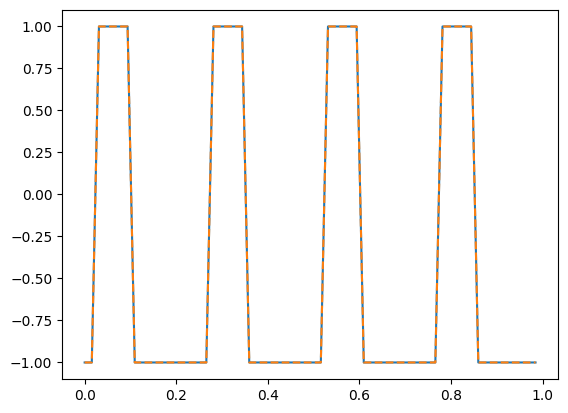

In [24]:
L = 1 
Np_ref = 64
grid_1d = torch.linspace(0, L, Np_ref+1,dtype=torch.double)[np.newaxis, np.newaxis, 0:-1]
weights = torch.ones(1,1,Np_ref,dtype=torch.double)/Np_ref
mask = torch.ones(1,1,Np_ref,dtype=torch.double)
x = np.sin(2*np.pi*grid_1d*4)
x = torch.where(x > 0.5, torch.tensor(1.0, dtype=torch.double), torch.tensor(-1.0, dtype=torch.double))


modes = torch.tensor(compute_Fourier_modes_helper(1, [Np_ref//2], [L]))
speconv = SpectralConv(1,1,modes)
bases_c, bases_s, bases_0 = compute_Fourier_bases(grid_1d, modes, mask)
wbases_c, wbases_s, wbases_0 = bases_c*weights , bases_s*weights, bases_0*weights 
     
x_conv = speconv(x, wbases_c, wbases_s, wbases_0, bases_c, bases_s, bases_0)

plt.plot(grid_1d[0,0,:], x[0,0,:])
plt.plot(grid_1d[0,0,:], x_conv[0,0,:], "--")

print("norm(x - x_conv) = ", np.linalg.norm(x - x_conv))
